# Baseline Model


In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

use_cuda=True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import time
import matplotlib.pyplot as plt

## Load Data

In [0]:
from zipfile import ZipFile
# import urllib.request
# url = 'https://github.com/SarhadSalam/APS360_Final_Project/blob/master/sample_data/trousers.zip'
file_name = "trousers.zip"
# urllib.request.urlretrieve(url, file_name)
ZipFile(file_name).extractall()

In [0]:
os.getcwd()

'/content'

In [0]:
!ls

filtered  sample_data  trousers.zip


In [0]:
import PIL
def get_clothes_dataset():
    """
    Load the data into an ImageFolder dataset and print the number of data points
    Returns:
      full_data_set: ImageFolder dataset object with all the gesture data points
    """
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose([
        transforms.Resize((100,50)),
        transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))         
         ])
         
    
    # Get data
    dataset_path = "trousers/"
   
    def pil_loader_RGBA(path):
      # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
      with open(path, 'rb') as f:
          img = PIL.Image.open(f)
          return img.convert('RGBA')

    full_data_set = datasets.ImageFolder(dataset_path, transform=transform, loader=pil_loader_RGBA)
    print("Number of data points is {}".format(len(full_data_set)))
    return full_data_set

In [6]:
data_set = get_clothes_dataset()

Number of data points is 360


In [0]:
data_set[0][0].shape

torch.Size([4, 100, 50])

In [0]:
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(full_data_set, batch_size, data_samples = -1):
    """ Generates training, validation and testing data loader for the relevant 
    target classes for a given batch size.

    Args:
        full_data_set: Dataset object containing data points to be split into 
                        training, validation and test put into data loaders
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: size per batch
        data_samples: integer number of data samples to use, defaults to -1 to use all
                      data points
    Returns:
        training, validation and testing data loaders with a distribution of 
        60:30:10
    """
  
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    torch.manual_seed(1000)

    classes = ["edges", "filtered", "whites"]
    target_classes = ("filtered")
    relevant_indices = get_relevant_indices(full_data_set, classes, target_classes)
    # relevant_indices = list(range(len(full_data_set)))
    # np.random.shuffle(relevant_indices)

    split = int(data_samples/2)

    if data_samples == -1 or data_samples >= len(relevant_indices):
      split = int(len(relevant_indices)/2)
    
    
    # print("Train loader")
    train_sampler = SubsetRandomSampler(relevant_indices)
    train_loader = torch.utils.data.DataLoader(full_data_set, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    
    return train_loader

In [0]:
train_loader = get_data_loader(data_set, 1)

torch.Size([100, 50, 4])


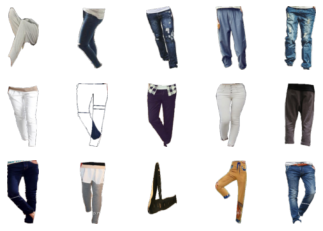

In [9]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        print(img.size())
        break

# Model
Use convolutional layers mainly as we want to use feature data!

In [0]:
# Taken from APS360 tutorial
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(4, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU(),
            nn.Conv2d(64, 128, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
def train(model, train_loader, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    
    outputs = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        i = 0
        img = None
        recon = None
        for data in train_loader:
            img, _ = data
            recon = model(img)
            # print(recon.shape)
            recon = recon[:, :, :, :50]
            loss = criterion(recon, img)
            total_loss += loss
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            i += 1
        outputs.append((epoch, img, recon))
        print('Epoch {}, Loss: {:.4f}'.format(epoch+1, float(total_loss/i)))
    return outputs

In [0]:
model = Autoencoder()
train_loader = get_data_loader(data_set, 5)
outputs = train(model, train_loader, num_epochs=400, batch_size=5, learning_rate = 1e-3)

Epoch 1, Loss: 0.5976
Epoch 2, Loss: 0.4338
Epoch 3, Loss: 0.3821
Epoch 4, Loss: 0.3511
Epoch 5, Loss: 0.3198
Epoch 6, Loss: 0.2773
Epoch 7, Loss: 0.2461
Epoch 8, Loss: 0.2150
Epoch 9, Loss: 0.1808
Epoch 10, Loss: 0.1585
Epoch 11, Loss: 0.1484
Epoch 12, Loss: 0.1445
Epoch 13, Loss: 0.1323
Epoch 14, Loss: 0.1199
Epoch 15, Loss: 0.1109
Epoch 16, Loss: 0.1077
Epoch 17, Loss: 0.1016
Epoch 18, Loss: 0.0976
Epoch 19, Loss: 0.0975
Epoch 20, Loss: 0.0941
Epoch 21, Loss: 0.0884
Epoch 22, Loss: 0.0847
Epoch 23, Loss: 0.0796
Epoch 24, Loss: 0.0759
Epoch 25, Loss: 0.0767
Epoch 26, Loss: 0.0743
Epoch 27, Loss: 0.0721
Epoch 28, Loss: 0.0735
Epoch 29, Loss: 0.0718
Epoch 30, Loss: 0.0661
Epoch 31, Loss: 0.0622
Epoch 32, Loss: 0.0603
Epoch 33, Loss: 0.0602
Epoch 34, Loss: 0.0590
Epoch 35, Loss: 0.0599
Epoch 36, Loss: 0.0603
Epoch 37, Loss: 0.0609
Epoch 38, Loss: 0.0592
Epoch 39, Loss: 0.0604
Epoch 40, Loss: 0.0581
Epoch 41, Loss: 0.0566
Epoch 42, Loss: 0.0541
Epoch 43, Loss: 0.0553
Epoch 44, Loss: 0.05

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model_path = "drive/My Drive/aps360_bl_model"

In [0]:
torch.save(model.state_dict(), model_path)

In [14]:
model = Autoencoder()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Training Results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


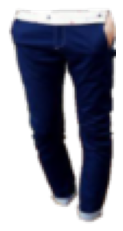

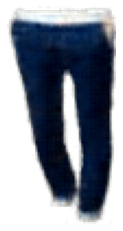

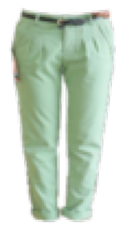

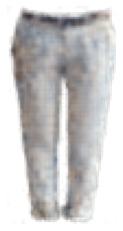

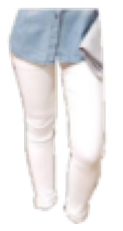

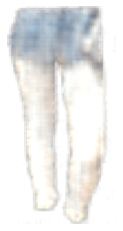

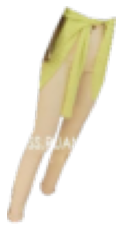

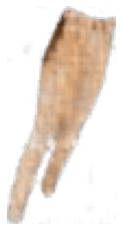

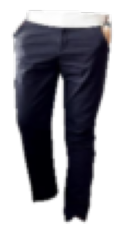

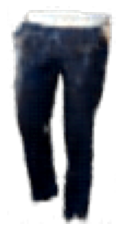

In [0]:
k = 0

final_train_imgs = outputs[-1][1]
final_train_recon = outputs[-1][2]

for i in range(len(final_train_imgs)):
    img = final_train_imgs[i]
    recon = final_train_recon[i]

    image = img.detach().numpy()
    image = np.transpose(image, [1,2,0])
    image = image / 2 + 0.5

    # since batch_size = 1, there is only 1 image in `images`
    rec = recon.detach().numpy()
    # place the colour channel at the end, instead of at the beginning
    rec = rec/2 + 0.5
    rec = np.transpose(rec, [1,2,0])

    plt.figure()
    plt.axis('off')
    plt.imshow(image)

    plt.figure()
    plt.axis('off')
    plt.imshow(rec)
    k +=1
    if k > 10:
      break

In [0]:
outputs[-1][1].shape

torch.Size([1, 4, 100, 50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


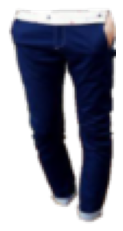

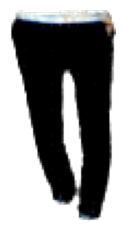

In [0]:
# for output in outputs:
#   img, recon = output[1], output[2]

# for output in outputs:
img, recon = outputs[-1][1], outputs[-1][2]
# since batch_size = 1, there is only 1 image in `images`
image = img[0].detach().numpy()
# place the colour channel at the end, instead of at the beginning
image = np.transpose(image, [1,2,0])
# print(image)
# print(image.shape)
# normalize pixel intensity values to [0, 1]
image = image / 2 + 0.5

# since batch_size = 1, there is only 1 image in `images`
rec = recon[0].detach().numpy()
# place the colour channel at the end, instead of at the beginning
# rec[:3] = rec[:3]/2 + 0.5
rec = np.transpose(rec, [1,2,0])
# normalize pixel intensity values to [0, 1]
# rec = rec / 2 + 0.5
# print(np.max(rec))

plt.figure()
plt.axis('off')
plt.imshow(image)

plt.figure()
plt.axis('off')
plt.imshow(rec)

# Testing Baseline
Try inputting edges into the baseline model and see what happens :)

In [0]:
def get_test_loader(full_data_set, data_samples = -1):
    """ Generates training, validation and testing data loader for the relevant 
    target classes for a given batch size.

    Args:
        full_data_set: Dataset object containing data points to be split into 
                        training, validation and test put into data loaders
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: size per batch
        data_samples: integer number of data samples to use, defaults to -1 to use all
                      data points
    Returns:
        training, validation and testing data loaders with a distribution of 
        60:30:10
    """
  
    # Get the doodles
    classes = ("edges", "filtered", "whites")
    target_classes = ("whites")
    relevant_indices = get_relevant_indices(full_data_set, classes, target_classes)

    if data_samples != -1:
        relevant_indices = relevant_indices[:data_samples]
    
    # print("Test loader")
    test_sampler = SubsetRandomSampler(relevant_indices)
    test_loader = torch.utils.data.DataLoader(full_data_set, batch_size=1,
                                             num_workers=1, sampler=test_sampler)
    return test_loader

Displaying test data samples, that is, the doodles

torch.Size([100, 50, 4])


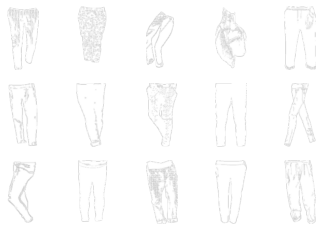

In [16]:
test_loader = get_test_loader(data_set)
k = 0
for images, labels in test_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        print(img.size())
        break

Now let's see what happens when we put the doodles into the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

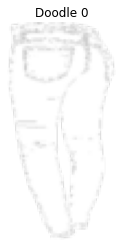

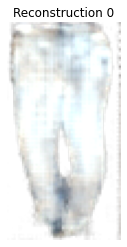

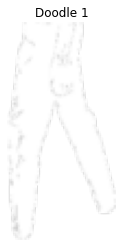

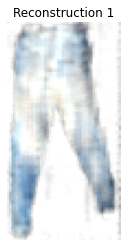

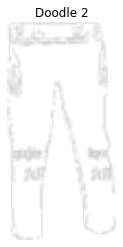

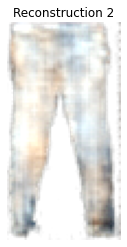

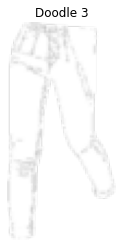

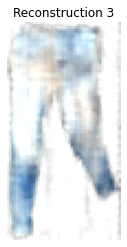

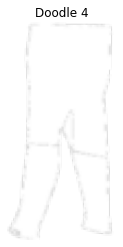

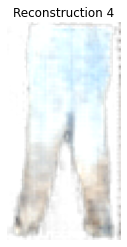

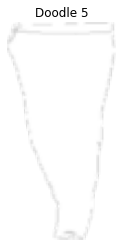

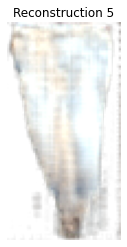

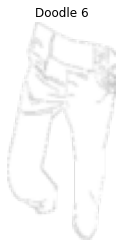

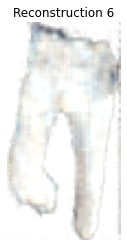

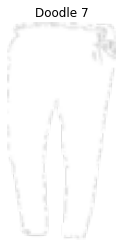

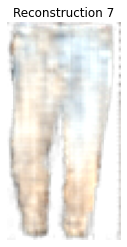

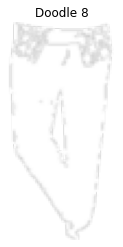

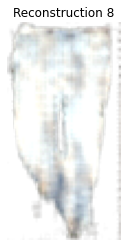

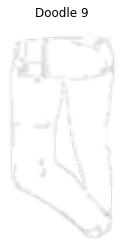

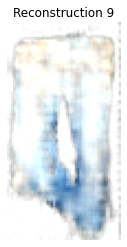

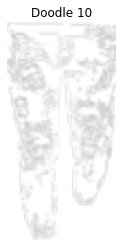

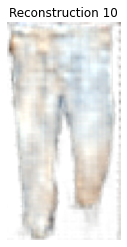

In [19]:
test_loader = get_test_loader(data_set)
k = 0
for data in test_loader:
    img, _ = data
    recon = model(img)

    image = img[0].detach().numpy()
    image = np.transpose(image, [1,2,0])
    image = image / 2 + 0.5

    # since batch_size = 1, there is only 1 image in `images`
    rec = recon[0].detach().numpy()
    # place the colour channel at the end, instead of at the beginning
    rec = rec/2 + 0.5
    rec = np.transpose(rec, [1,2,0])

    plt.figure()
    plt.axis('off')
    plt.imshow(image)
    plt.title(f'Doodle {k}')
    plt.figure()
    plt.axis('off')
    plt.imshow(rec)
    plt.title(f'Reconstruction {k}')

    k +=1
    if k > 10:
      break